# Introdu√ß√£o ao Projeto de Modelagem Preditiva do IBOVESPA

Fomos escalados para integrar o time de investimentos com o objetivo de desenvolver um modelo preditivo capaz de prever o fechamento di√°rio do √≠ndice IBOVESPA, principal indicador do desempenho das a√ß√µes negociadas na B3 (Bolsa de Valores do Brasil). A precis√£o dessas previs√µes √© fundamental para informar nossas estrat√©gias de investimento e tomada de decis√£o. Este projeto envolver√° uma abordagem completa, desde a coleta dos dados at√© a entrega do modelo final, acompanhado de uma justificativa clara para a t√©cnica escolhida.

## Importa√ß√µes e instala√ß√µes de bibliotecas necess√°rias

In [293]:
!pip install statsforecast

In [294]:
!pip install pmdarima


In [295]:
!pip install statsmodels

In [296]:
!pip install prophet

In [297]:
!pip install xgboost

In [298]:
!pip install seaborn

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,make_scorer
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
warnings.filterwarnings('ignore')

## Leitura, explora√ß√£o e adequa√ß√£o do Dataset:
Fonte: https://br.investing.com/indices/bovespa-historical-data

Per√≠odo: 21-07-2020 a 19-07-2024.



In [300]:
df = pd.read_csv('ibovespa_2020_2024.csv', parse_dates=[0], dtype={'√öltimo': str,'Abertura':str})
df.head()

Data   √öltimo Abertura   M√°xima   M√≠nima   Vol.    Var%
0 2024-07-19  127.616  127.652  128.360  127.413  7,62M  -0,03%
1 2024-07-18  127.652  129.450  129.454  127.523  7,59M  -1,39%
2 2024-07-17  129.450  129.112  129.658  128.741  6,67M   0,26%
3 2024-07-16  129.110  129.322  129.521  128.761  6,82M  -0,16%
4 2024-07-15  129.321  128.898  129.485  128.723  5,83M   0,33%

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      996 non-null    datetime64[ns]
 1   √öltimo    996 non-null    object        
 2   Abertura  996 non-null    object        
 3   M√°xima    996 non-null    float64       
 4   M√≠nima    996 non-null    float64       
 5   Vol.      996 non-null    object        
 6   Var%      996 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 54.6+ KB


In [302]:
df_novo = df[['Data', '√öltimo','Abertura']]
df_novo = df_novo.rename(columns={'√öltimo': 'y', 'Data': 'ds','Abertura':'abertura'})
df_novo = df_novo.set_index('ds').sort_index()
df_novo.head()

y abertura
ds                          
2020-07-21  104.310  104.426
2020-07-22  104.290  104.312
2020-07-23  102.293  104.291
2020-07-24  102.382  102.292
2020-07-27  104.477  102.381

In [303]:
df_novo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-07-21 to 2024-07-19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   y         996 non-null    object
 1   abertura  996 non-null    object
dtypes: object(2)
memory usage: 23.3+ KB


In [304]:
df_novo['y'] = df_novo['y'].str.replace('.', '').astype(int)
df_novo['abertura'] = df_novo['abertura'].str.replace('.', '').astype(int)

In [305]:
df_novo.tail()

y  abertura
ds                          
2024-07-15  129321    128898
2024-07-16  129110    129322
2024-07-17  129450    129112
2024-07-18  127652    129450
2024-07-19  127616    127652

In [306]:
df_novo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2020-07-21 to 2024-07-19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   y         996 non-null    int64
 1   abertura  996 non-null    int64
dtypes: int64(2)
memory usage: 23.3 KB


In [307]:
df_novo.describe()

y       abertura
count     996.000000     996.000000
mean   114310.898594  114288.108434
std      9268.946347    9264.290646
min     93580.000000   93586.000000
25%    107237.000000  107166.250000
50%    114062.000000  114038.500000
75%    120702.250000  120701.000000
max    134194.000000  134194.000000

In [308]:
df_novo.isnull().sum()

y           0
abertura    0
dtype: int64

## An√°lise Visual do Dataset

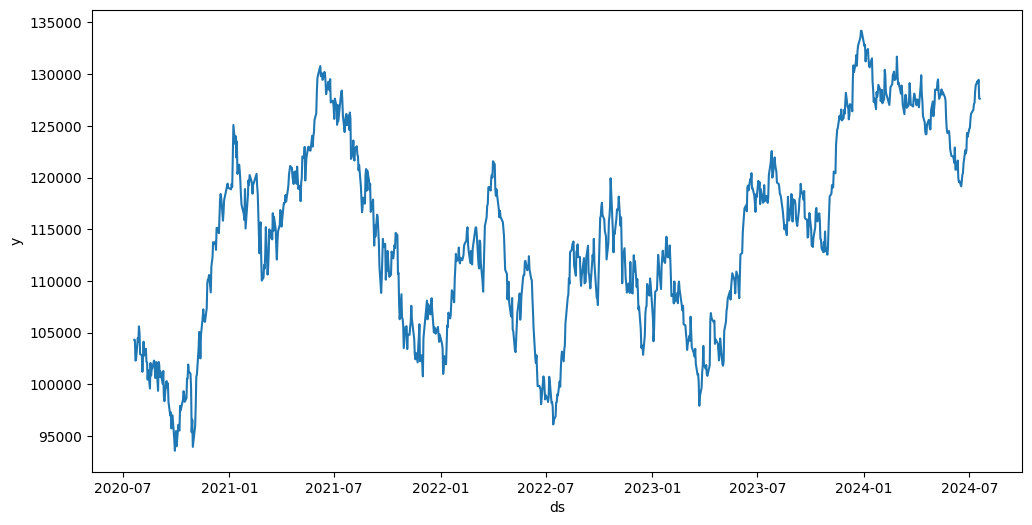

In [309]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=df_novo)
plt.show()

In [310]:
#Preenchendo os finais de semana com valor do dia anterior
df_diario = df_novo.asfreq('D')
df_diario.fillna(method='ffill', inplace=True)

In [311]:
df_diario = df_diario.astype(int)

In [312]:
df_diario.head()

y  abertura
ds                          
2020-07-21  104310    104426
2020-07-22  104290    104312
2020-07-23  102293    104291
2020-07-24  102382    102292
2020-07-25  102382    102292

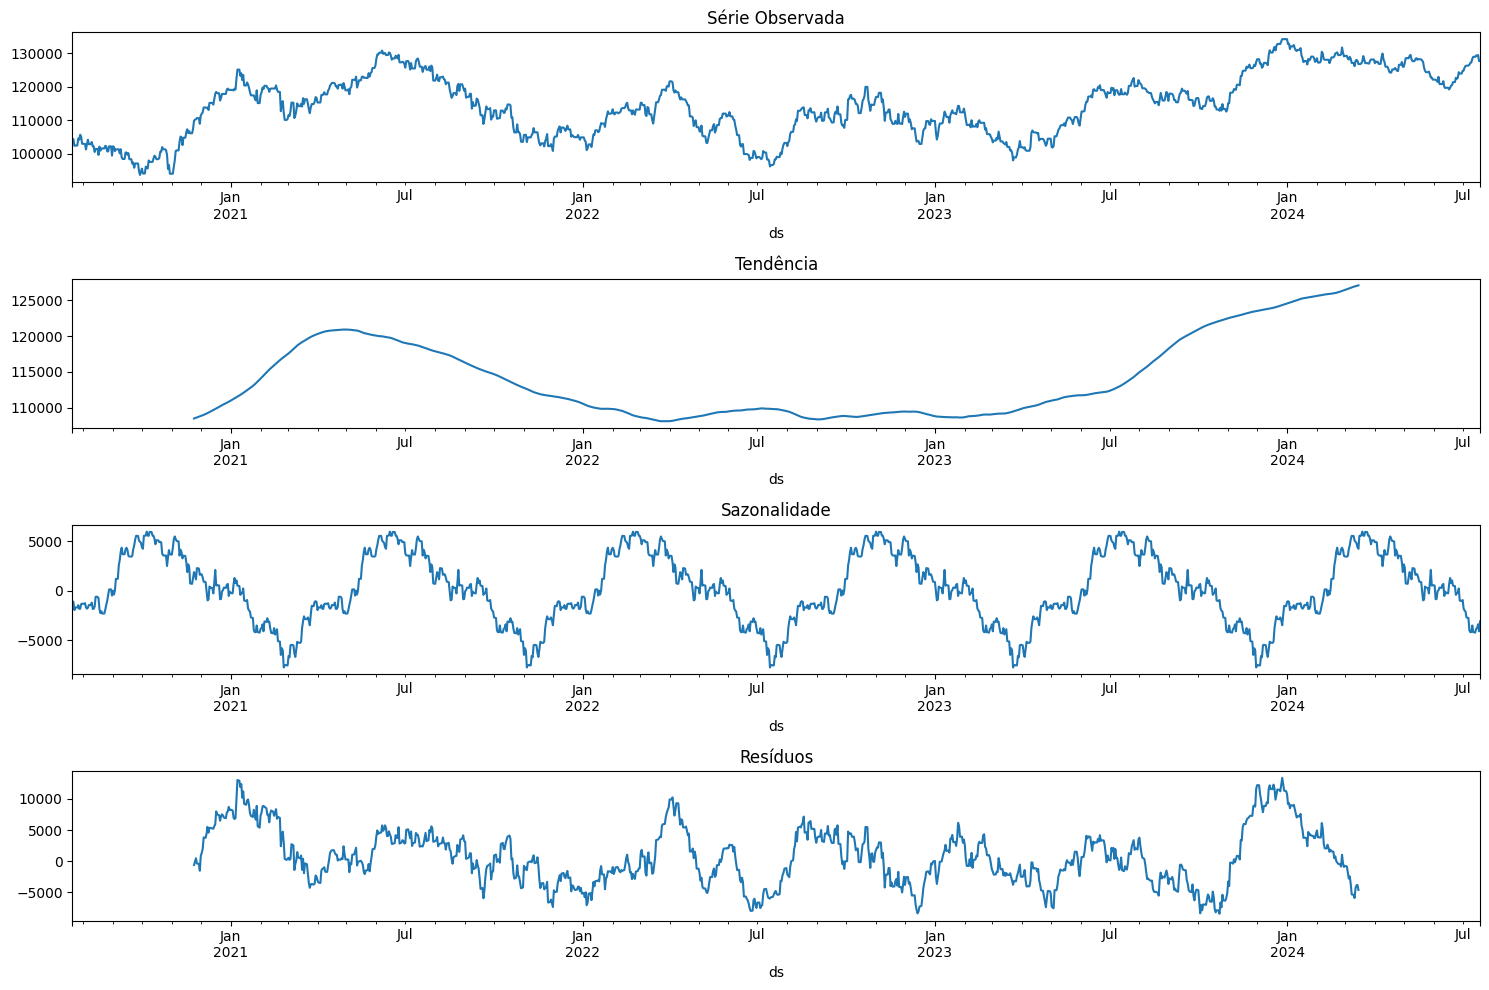

In [313]:
# period = 252 corresponde a quantidade de dias de um ano √∫til
resultados = seasonal_decompose(df_diario['y'], model='additive',period=252)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title('S√©rie Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Tend√™ncia')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Res√≠duos')

plt.tight_layout()

### An√°lise do Seasonal Decompese

**Gr√°fico da S√©rie Observada:**

O gr√°fico da s√©rie observada mostra o comportamento do √≠ndice IBOVESPA ao longo do tempo, com dados di√°rios. Podemos notar varia√ß√µes significativas, refletindo a volatilidade t√≠pica do mercado de a√ß√µes.

**Gr√°fico da Tend√™ncia:**

O componente de tend√™ncia captura o movimento geral de longo prazo do √≠ndice. Observamos um aumento inicial at√© aproximadamente o meio de 2021, seguido por uma tend√™ncia de queda at√© o in√≠cio de 2023. A partir da√≠, a tend√™ncia volta a subir at√© o final do per√≠odo observado em 2024. Essa informa√ß√£o √© √∫til para entender a dire√ß√£o geral do mercado ao longo do tempo, mostrando que acontecimentos externos influenciam de forma significativa essa tend√™ncia, como a pandemia da COVID-19.

**Gr√°fico da Sazonalidade:**

O componente sazonal mostra padr√µes que se repetem em intervalos regulares. Considerando que o √≠ndice IBOVESPA t√™m registros somente nos dias √∫teis, para esse gr√°fico utilizamos o par√¢metro de periodo com o valor de 252 dias, o que corresponde aproximadamente ao total de dias √∫teis de um ano. Diante dessa configura√ß√£o, conseguimos visualizar uma sazonalidade que se repete aproximadamente a cada ano.

**Gr√°fico de Res√≠duos:**

Como o gr√°fico de res√≠duos representa o que resta da s√©rie temporal ap√≥s a remo√ß√£o dos componentes de tend√™ncia e sazonalidade, o ideal √© que os res√≠duos devem parecer ru√≠do branco, sem padr√µes vis√≠veis, o que √© identificado no gr√°fico exposto.

## An√°lise da tend√™ncia

In [314]:
df_tendencia = df_diario.reset_index().copy()

df_tendencia['data_ordinal'] = df_tendencia['ds'].map(pd.Timestamp.toordinal)

X = df_tendencia[['data_ordinal']]
y = df_tendencia['y']

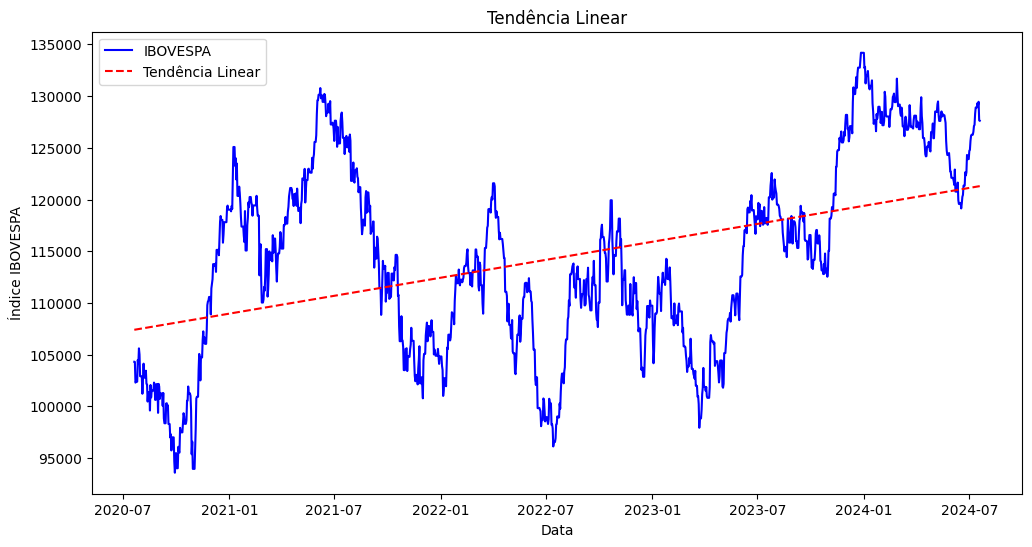

In [315]:
model = LinearRegression()
model.fit(X, y)

# Previs√µes
df_tendencia['tendencia'] = model.predict(X)

# Plotar os dados
plt.figure(figsize=(12, 6))
plt.plot(df_tendencia['ds'], df_tendencia['y'], label='IBOVESPA', color='blue')
plt.plot(df_tendencia['ds'], df_tendencia['tendencia'], label='Tend√™ncia Linear', color='red', linestyle='--')
plt.xlabel('Data')
plt.ylabel('√çndice IBOVESPA')
plt.title('Tend√™ncia Linear')
plt.legend()
plt.show()

### An√°lise do Gr√°fico de Tend√™ncia Linear

Utizamos o Modelo de Regress√£o Linear para verificar a tend√™ncia da s√©rie temporal analisada. Conforme exposto no gr√°fico acima, verificamos que a s√©rie possui uma tend√™ncia de crescimento. Sendo um comportamento esperado √† longo prazo de s√©ries temporais que representam √≠ndices de bolsas de valores.

## An√°lise da M√©dia Movel de 30 dias

In [316]:
# M√©dias mov√©is
df_medias_moveis = df_diario.copy()
# Calcular m√©dias m√≥veis
df_medias_moveis['MA30'] = df_medias_moveis['y'].rolling(window=30).mean()

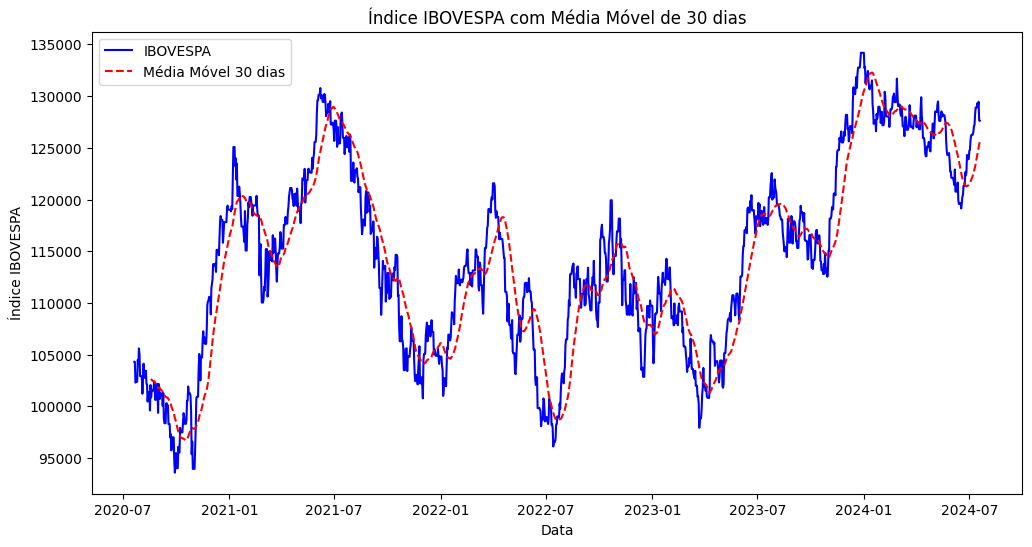

In [317]:
plt.figure(figsize=(12, 6))

# Plotar o √≠ndice IBOVESPA
plt.plot(df_medias_moveis.index, df_medias_moveis['y'], label='IBOVESPA', color='blue')

# Plotar as m√©dias m√≥veis
plt.plot(df_medias_moveis.index, df_medias_moveis['MA30'], label='M√©dia M√≥vel 30 dias', color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('√çndice IBOVESPA')
plt.title('√çndice IBOVESPA com M√©dia M√≥vel de 30 dias')
plt.legend()
plt.show()

### An√°lise do Gr√°fico √çndice IBOVESPA com M√©dia Movel de 30 dias

A linha vermelha tracejada mostra a m√©dia m√≥vel de 30 dias do √≠ndice IBOVESPA. A m√©dia m√≥vel suaviza as flutua√ß√µes di√°rias, facilitando a identifica√ß√£o de tend√™ncias subjacentes.
A m√©dia m√≥vel de 30 dias acompanha bem as tend√™ncias gerais da s√©rie temporal, eliminando os picos e vales extremos e apresentando uma vis√£o mais clara dos movimentos de longo prazo.
Observa-se que a m√©dia m√≥vel de 30 dias √© mais suave e revela padr√µes mais consistentes, como a tend√™ncia de queda em 2021 e a recupera√ß√£o posterior.

## Auto correla√ß√£o

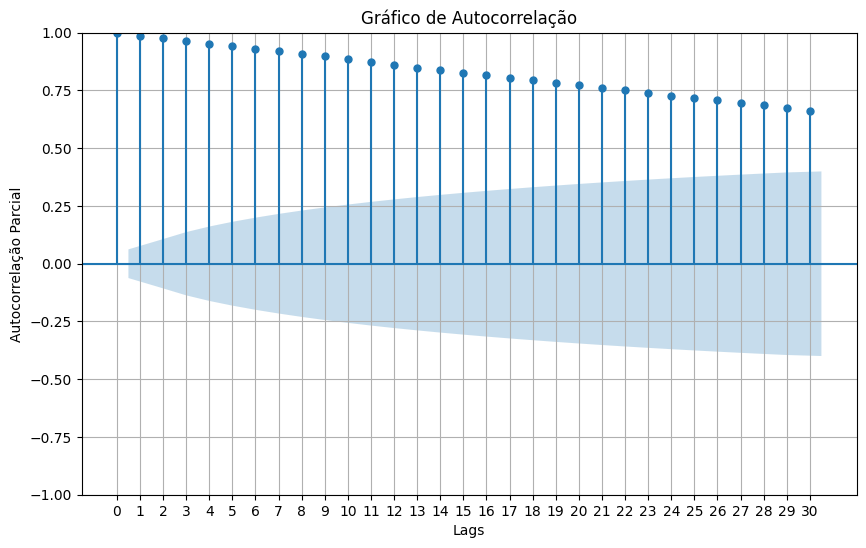

In [318]:
# Plotar o gr√°fico de autocorrela√ß√£o parcial com personaliza√ß√µes
fig, ax = plt.subplots(figsize=(10, 6))

# Gr√°fico de autocorrela√ß√£o parcial
plot_acf(df_novo['y'], ax=ax)

# Adicionar grade
ax.grid(True)

# Diminuir o intervalo de ticks
ax.set_xticks(range(0, 31, 1))  # Ajustar o intervalo de ticks no eixo X para cada lag de 1 a 30

# T√≠tulos e r√≥tulos
ax.set_title('Gr√°fico de Autocorrela√ß√£o')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrela√ß√£o Parcial')

plt.show()


### An√°lise do Gr√°fico de Auto Correla√ß√£o

Observamos no gr√°fico de Auto Correla√ß√£o que a primeira barra vertical √© igual 1 o que indica uma alta correla√ß√£o entre os valores consecutivos da s√©rie temporal. As barras verticais decresce a medida que os n√∫meros de lags aumenta, mas ainda permanecem acima de 0.75 at√© o lag 22, isso sugere que h√° uma forte correla√ß√£o positiva entre os valores da s√©rie temporal para lags relativamente longos.

√â poss√≠vel observar tamb√©m que as barras verticais est√£o acima do intervalo de confian√ßa, indicando que as altas correla√ß√µes s√£o estatiscamente significativas. A persist√™ncia dessa correla√ß√£o acima do intervalo de confian√ßa sugere que a s√©rie temporal tem uma estrutura de depend√™ncia forte e n√£o √© aleat√≥ria.

A auto correla√ß√£o positiva e lenta diminui√ß√£o das barras indicam que a s√©rie temporal provavelmente n√£o √© estacion√°rio e pode ter um tend√™ncia.

## Auto Correla√ß√£o Parcial

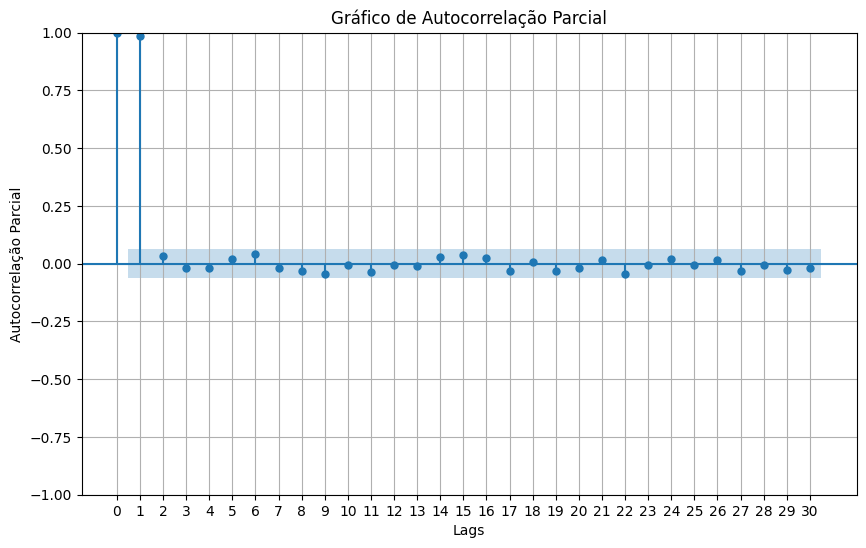

In [319]:
# Plotar o gr√°fico de autocorrela√ß√£o parcial com personaliza√ß√µes
fig, ax = plt.subplots(figsize=(10, 6))

# Gr√°fico de autocorrela√ß√£o parcial
plot_pacf(df_novo['y'], ax=ax)

# Adicionar grade
ax.grid(True)

# Diminuir o intervalo de ticks
ax.set_xticks(range(0, 31, 1))  # Ajustar o intervalo de ticks no eixo X para cada lag de 1 a 30

# T√≠tulos e r√≥tulos
ax.set_title('Gr√°fico de Autocorrela√ß√£o Parcial')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrela√ß√£o Parcial')

plt.show()


### An√°lise do Gr√°fico de Correla√ß√£o Parcial

Observamos que as barras caem drasticamente ap√≥s o lag 1 e permanecem pr√≥ximas de zero, o que indica que a s√©rie temporal n√£o possui uma forte autocorrela√ß√£o parcial al√©m do primeiro lag. Isso sugere que a maior parte da correla√ß√£o na s√©rie est√° explicada pelos valores no lag 1.

As barras est√£o pr√≥ximas de zero e dentro dos intervalos de confian√ßa a partir do lag 2. Isso significa que as correla√ß√µes parciais para esses lags n√£o s√£o estatisticamente significativas.

Conclu√≠mos ent√£o que apenas at√© a lag 1 tem signific√¢ncia estatistica.

## Estacionariedade

Os gr√°ficos de ACF e PACF sugeriram a n√£o estacionariedade. Contudo, iremos utilizar o m√©todo de Dick Fuller para confirmar.

In [320]:
# Estacion√°ria ou n√£o estacion√°ria

# ADF - Augmented Dickey Fuller

# H0 - Hip√≥tese Nula (n√£o √© estacion√°ria)
# H1 - Hip√≥tese Alternativa (rejei√ß√£o da hip√≥tese nula)

# p -value = 0.05 (5%), ent√£o rejeitamos H0 com um n√≠vel de confian√ßa de 95%

X = df_novo.y.values
resultado_adf = adfuller(X)

print("Teste ADF")
print(f"Teste Estat√≠stico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores cr√≠ticos:")

for key, value in resultado_adf[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estat√≠stico: -2.204784030301742
P-Value: 0.2045137141109739
Valores cr√≠ticos:
	1%: -3.4369391965679257
	5%: -2.86444914142694
	10%: -2.5683189679553546


### An√°lise do Resultado do m√©todo de Dick Fuller

O p-valor de 0.2045137141109739 √© maior que 0.05, indicando que n√£o h√° evid√™ncia suficiente para rejeitar a hip√≥tese nula de n√£o estacionaridade.

Al√©m disso, o teste estat√≠stico (-2.204784030301742) √© maior do que todos os valores cr√≠ticos (em termos absolutos), especialmente o valor cr√≠tico de 5% (-2.86444914142694) e o valor cr√≠tico de 10% (-2.5683189679553546).

Confirmando assim, que n√£o podemos rejeitar a hip√≥tese nula de que a s√©rie tem uma raiz unit√°ria (n√£o √© estacion√°ria).

## Diferencia√ß√£o para tornar a s√©rie estacion√°ria

In [321]:
# Estacion√°ria ou n√£o estacion√°ria

# ADF - Augmented Dickey Fuller

# H0 - Hip√≥tese Nula (n√£o √© estacion√°ria)
# H1 - Hip√≥tese Alternativa (rejei√ß√£o da hip√≥tese nula)

# p -value = 0.05 (5%), ent√£o rejeitamos H0 com um n√≠vel de confian√ßa de 95%

df_diff = df_novo.diff().dropna()

X = df_diff.y.values
resultado_adf = adfuller(X)

print("Teste ADF")
print(f"Teste Estat√≠stico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores cr√≠ticos:")

for key, value in resultado_adf[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estat√≠stico: -32.959911372270746
P-Value: 0.0
Valores cr√≠ticos:
	1%: -3.43694584277544
	5%: -2.8644520725172873
	10%: -2.5683205291305176


### An√°lise da Diferencia√ß√£o

Com apenas uma diferencia√ß√£o foi poss√≠vel rejeitar a hip√≥tese nula (p-value menor 0.05). Indicando que a s√©rie se tornou estacion√°rio com apenas uma diferencia√ß√£o.

## Fun√ß√µes para calcular e imprimir as m√©tricas de erros

As m√©tricas escolhidas foram o Erro M√©dio Absoluto (MAE), Erro Quadr√°tico M√©dio (MSE) e Erro Percentual Absoluto M√©dio (MAPE).

In [322]:
def calculate_errors(y_true, y_pred):
    """
    Calcula o MAE, MSE e MAPE.

    Par√¢metros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.

    Retorna:
    dict: Um dicion√°rio contendo MAE, MSE e MAPE.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {'MAE': mae, 'MSE': mse, 'MAPE': mape}

In [323]:
def print_errors(y_true, y_pred):
    """
    Calcula e imprime os erros MAE, MSE e MAPE.

    Par√¢metros:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.
    """
    errors = calculate_errors(y_true, y_pred)

    print(f"MAE (Mean Absolute Error): {errors['MAE']}")
    print(f"MSE (Mean Squared Error): {errors['MSE']}")
    print(f"MAPE (Mean Absolute Percentage Error): {errors['MAPE']}%")

## Dividindo o dataset em treino e valida√ß√£o

Divimos o dataset em treino e valida√ß√£o para criarmos os modelos. Decidimos iniciar o dataset de valida√ß√£o em uma quarta-feira (10/07/2024), para que a valida√ß√£o n√£o iniciasse no final de semana, onde os valores s√£o iguais √† sexta-feira anterior. Al√©m disso, definimos o tamanho desse dataset de valida√ß√£o em 7 dias (10/07/2024 a 16/07/2024).

In [324]:
df_modelo = df_diario.copy()

In [325]:
# Dividir o dataframe em treino e valida√ß√£o (usando para valida√ß√£o 7 dias come√ßando no meio da semana)
train_size = df_modelo.shape[0] -10
train_df = df_modelo[:train_size]#.astype(int)
val_df = df_modelo[train_size:-3]#.astype(int)

In [326]:
train_df.tail(9)

y  abertura
ds                          
2024-07-01  124718    123905
2024-07-02  124787    124720
2024-07-03  125662    124787
2024-07-04  126164    125666
2024-07-05  126267    126165
2024-07-06  126267    126165
2024-07-07  126267    126165
2024-07-08  126548    126280
2024-07-09  127108    126548

In [327]:
val_df

y  abertura
ds                          
2024-07-10  127218    127109
2024-07-11  128294    127221
2024-07-12  128897    128293
2024-07-13  128897    128293
2024-07-14  128897    128293
2024-07-15  129321    128898
2024-07-16  129110    129322

In [328]:
len(val_df)

7

##Modelo **ARIMA**

O modelo ARIMA (Autoregressive Integrated Moving Average), utilizado para previs√£o de s√©ries temporais, combina tr√™s componentes: AR (Autoregressive) com par√¢metro
ùëù
(n√∫mero de lags), I (Integrated) com par√¢metro
ùëë
(n√∫mero de diferencia√ß√µes para estacionariedade), e MA (Moving Average) com par√¢metro
ùëû
(n√∫mero de termos de erro).

**Escolha dos Hiperpar√¢metros:**


p (Autoregressive): √â utilizada a fun√ß√£o de autocorrela√ß√£o parcial (PACF) para identificar o n√∫mero de lags. Retornando ao gr√°fico PACF identificamos o valor do par√¢metro √© igual a 1.

d (Integrated): Utilizamos o teste de Dickey-Fuller para determinar a necessidade de diferencia√ß√£o e verificamos que apenas uma diferencia√ß√£o torna a s√©rie estacion√°ria.

q (Moving Average): Verificamos na literatura que a sugest√£o seria come√ßar com valores baixos e aumentar conforme necess√°rio, contudo valores muito altos demandam alto processamento. Chegamos a um valor de 7 como satisfat√≥rio.

In [329]:
# Treinar o modelo ARIMA
# (p, d, q) - s√£o provenientes da an√°lise dos gr√°ficos ACF e PACF
model_arima = ARIMA(train_df['y'], order=(1,1,7))
model_fit_arima = model_arima.fit()

In [330]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
forecast_start = len(train_df['y'])
forecast_end = forecast_start + len(val_df) - 1
forecast_arima = model_fit_arima.predict(start=forecast_start, end=forecast_end, typ='levels').astype(int)

In [331]:
# Transformar o forecast em uma S√©rie e garantir que o √≠ndice esteja correto
forecast_series_arima = pd.Series(forecast_arima, index=val_df.index)

In [332]:
forecast_series_arima.head()

ds
2024-07-10    127072
2024-07-11    127060
2024-07-12    127057
2024-07-13    127058
2024-07-14    127066
Freq: D, Name: predicted_mean, dtype: int64

In [333]:
# Calcular o erro de previs√£o
erros_arima = calculate_errors(val_df['y'], forecast_series_arima)
print_errors(val_df['y'], forecast_series_arima)

MAE (Mean Absolute Error): 1599.4285714285713
MSE (Mean Squared Error): 2993567.4285714286
MAPE (Mean Absolute Percentage Error): 1.2405201804801975%


In [334]:
# Selecionar os √∫ltimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

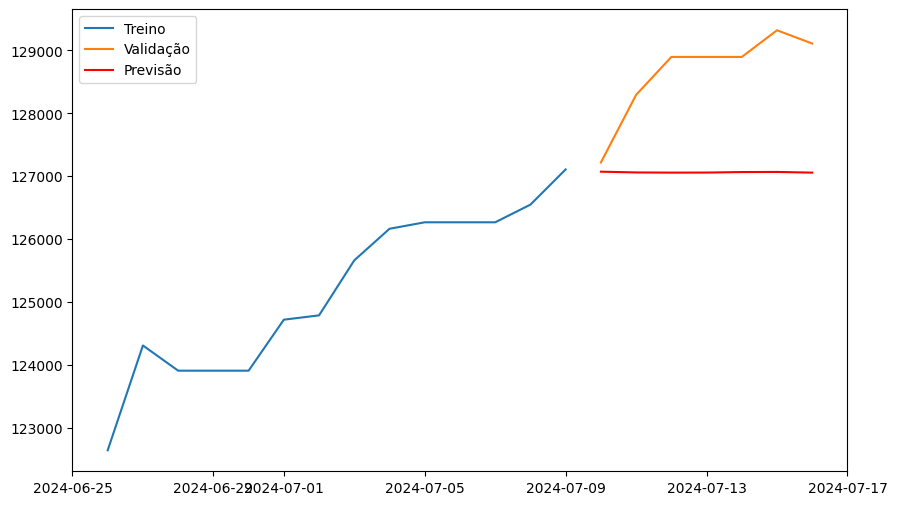

In [335]:
# Plotar resultados
plt.figure(figsize=(10, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Valida√ß√£o')
plt.plot(forecast_series_arima.index, forecast_series_arima, label='Previs√£o', color='red')
plt.legend()
plt.show()

## Modelo **SARIMA**

Verificamos com o algoritmo abaixo que os melhores valores para os hiperpar√¢metros s√£o:

p=0, d=1, q=0, P=0, D=0, Q=1, s=7

In [336]:
# Definir intervalo de valores para os hiperpar√¢metros
"""
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [7]  # Per√≠odos sazonais t√≠picos

best_aic = np.inf
best_params = None
best_model = None

for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        for s_val in s:
                            try:
                                # Ajustar o modelo SARIMA
                                model_sarima = SARIMAX(train_df['y'], order=(p_val, d_val, q_val),
                                                seasonal_order=(P_val, D_val, Q_val, s_val))
                                model_fit_sarima = model_sarima.fit(disp=False)

                                # Calcular o AIC
                                aic = model_fit_sarima.aic

                                # Comparar com o melhor AIC encontrado
                                if aic < best_aic:
                                    best_aic = aic
                                    best_params = (p_val, d_val, q_val, P_val, D_val, Q_val, s_val)
                                    best_model = model_fit_sarima
                            except:
                                continue

print(f'Best AIC: {best_aic}')
print(f'Best Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}, '
      f'P={best_params[3]}, D={best_params[4]}, Q={best_params[5]}, s={best_params[6]}')
"""


"\np = d = q = range(0, 3)\nP = D = Q = range(0, 2)\ns = [7]  # Per√≠odos sazonais t√≠picos\n\nbest_aic = np.inf\nbest_params = None\nbest_model = None\n\nfor p_val in p:\n    for d_val in d:\n        for q_val in q:\n            for P_val in P:\n                for D_val in D:\n                    for Q_val in Q:\n                        for s_val in s:\n                            try:\n                                # Ajustar o modelo SARIMA\n                                model_sarima = SARIMAX(train_df['y'], order=(p_val, d_val, q_val),\n                                                seasonal_order=(P_val, D_val, Q_val, s_val))\n                                model_fit_sarima = model_sarima.fit(disp=False)\n\n                                # Calcular o AIC\n                                aic = model_fit_sarima.aic\n\n                                # Comparar com o melhor AIC encontrado\n                                if aic < best_aic:\n                                    

In [337]:
model_sarima = SARIMAX(train_df['y'], order=(0, 1, 0), seasonal_order=(0, 0, 1, 7))
model_fit_sarima = model_sarima.fit(disp=False)

In [338]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
forecast_sarima = model_fit_sarima.get_forecast(steps=len(val_df))
forecast_series_sarima = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

In [339]:
# Calcular o erro de previs√£o
erros_sarima = calculate_errors(val_df['y'], forecast_series_sarima)
print_errors(val_df['y'], forecast_series_sarima)

MAE (Mean Absolute Error): 1593.5155897276065
MSE (Mean Squared Error): 2981995.092176362
MAPE (Mean Absolute Percentage Error): 1.2359024032012016%


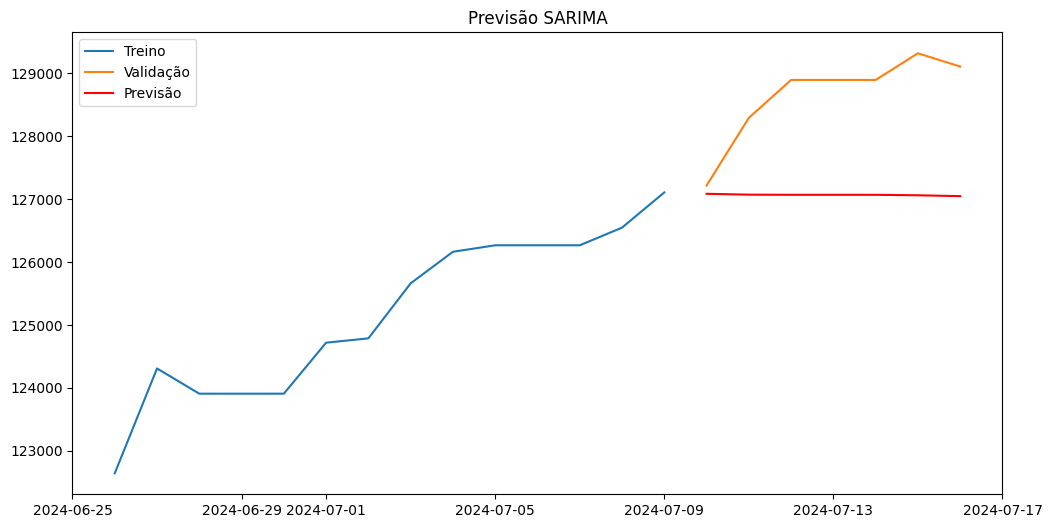

In [340]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Valida√ß√£o')
plt.plot(forecast_series_sarima.index, forecast_series_sarima, label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o SARIMA')
plt.show()

## Modelo **ExponentialSmoothing**

In [341]:
# Ajustar o modelo Holt-Winters (Exponential Smoothing)
# Configura√ß√µes: tend√™ncia aditiva e sazonalidade aditiva, sazonalidade di√°ria
model_exp_smoo = ExponentialSmoothing(train_df['y'], trend='add', seasonal='add', seasonal_periods=7)
model_fit_exp_smoo = model_exp_smoo.fit()

In [342]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
forecast_exp_smoo = model_fit_exp_smoo.forecast(steps=len(val_df))

In [343]:
# Transformar o forecast em uma S√©rie e garantir que o √≠ndice esteja correto
forecast_series_exp_smoo = pd.Series(forecast_exp_smoo, index=val_df.index)

In [344]:
# Calcular o erro de previs√£o
erros_exp_smoo = calculate_errors(val_df['y'], forecast_series_exp_smoo)
print_errors(val_df['y'], forecast_series_exp_smoo)

MAE (Mean Absolute Error): 1482.5118021208598
MSE (Mean Squared Error): 2562308.665361341
MAPE (Mean Absolute Percentage Error): 1.1498852823763492%


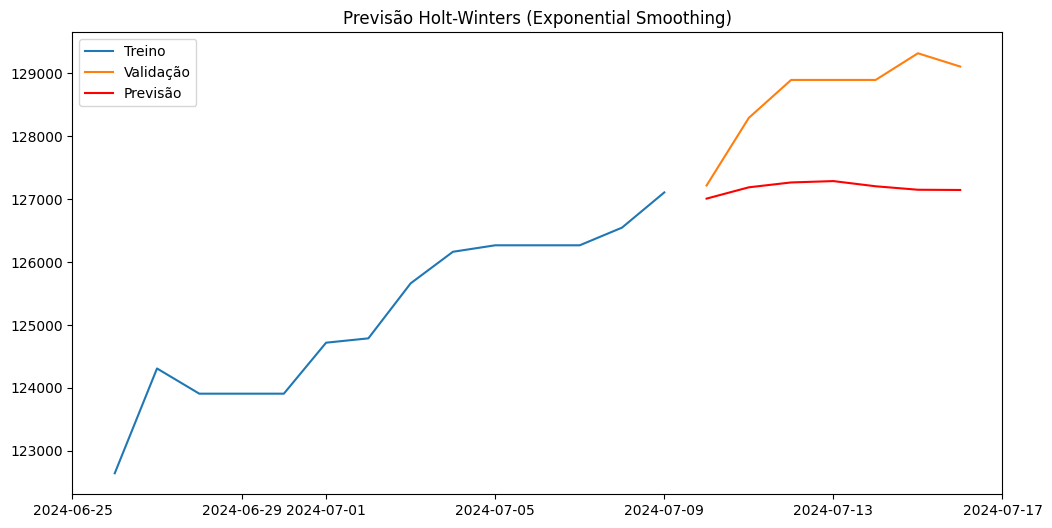

In [345]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Valida√ß√£o')
plt.plot(forecast_series_exp_smoo.index, forecast_series_exp_smoo, label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o Holt-Winters (Exponential Smoothing)')
plt.show()

## Modelo **Prophet**

In [346]:
df_modelo_prophet = df_modelo.reset_index()
df_modelo_prophet

ds       y  abertura
0    2020-07-21  104310    104426
1    2020-07-22  104290    104312
2    2020-07-23  102293    104291
3    2020-07-24  102382    102292
4    2020-07-25  102382    102292
...         ...     ...       ...
1455 2024-07-15  129321    128898
1456 2024-07-16  129110    129322
1457 2024-07-17  129450    129112
1458 2024-07-18  127652    129450
1459 2024-07-19  127616    127652

[1460 rows x 3 columns]

In [347]:
# Dividir o dataframe em treino e valida√ß√£o
train_size_prophet = df_modelo_prophet.shape[0] - 10
train_df_prophet = df_modelo_prophet[:train_size_prophet]
val_df_prophet = df_modelo_prophet[train_size_prophet:-3]


In [348]:
val_df_prophet.isnull().sum()

ds          0
y           0
abertura    0
dtype: int64

In [349]:
# Ajustar o modelo Prophet
#TO-DO: Faxer teste combinatorial para achar os melhores hiperpar√¢metros
model_prophet = Prophet(#seasonality_mode= 'additive',#'multiplicative',
                      #yearly_seasonality=False,
                      weekly_seasonality=True,
                      #daily_seasonality=True
                      )
#TO_DO: Trecho para incluir mais um dado. Talvez aqui incluir o valor do √≠ndice na abertura ou outro dado relevante
model_prophet.add_regressor("abertura")
model_prophet.fit(train_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/er8whuym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/c3c7go5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37339', 'data', 'file=/tmp/tmpr1k3cbpl/er8whuym.json', 'init=/tmp/tmpr1k3cbpl/c3c7go5b.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_model4f4djjd0/prophet_model-20240727171733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [350]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
future = model_prophet.make_future_dataframe(periods=len(val_df_prophet))
# Adicionar o regressor correspondente ao futuro DataFrame
future['abertura'] = val_df_prophet['abertura'].astype(int)
future['abertura'] = future['abertura'].fillna(0).astype(int)
forecast_prophet = model_prophet.predict(future)

In [351]:
# Extrair as previs√µes para o per√≠odo de valida√ß√£o
forecast_val = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[val_df_prophet['ds']]

In [352]:
# Calcular o erro de previs√£o
erros_prophet = calculate_errors(val_df_prophet['y'], forecast_val['yhat'])
print_errors(val_df_prophet['y'],forecast_val['yhat'])

MAE (Mean Absolute Error): 589.6697846688413
MSE (Mean Squared Error): 432613.1157362806
MAPE (Mean Absolute Percentage Error): 0.4579791256110229%


In [353]:
# Selecionar os √∫ltimos 14 registros de cada DataFrame
last_14_train = train_df_prophet.iloc[-14:]

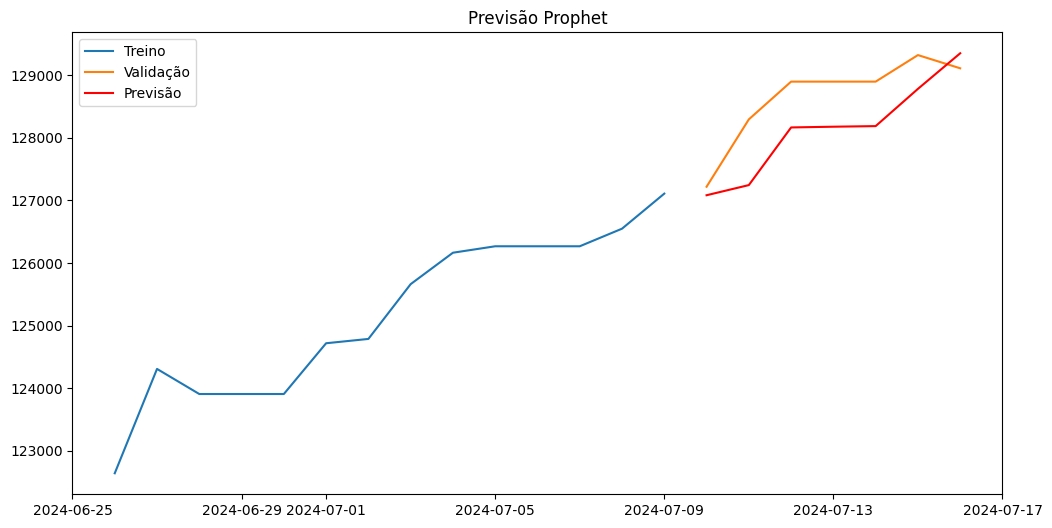

In [354]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train['ds'], last_14_train['y'], label='Treino')
plt.plot(val_df_prophet['ds'], val_df_prophet['y'], label='Valida√ß√£o')
plt.plot(forecast_val.index, forecast_val['yhat'], label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o Prophet')
plt.show()

## Modelo **SARIMAX**

Incorpora valore ex√¥genos

In [355]:
exog_train = train_df[["abertura"]]
exog_val = val_df[["abertura"]]

In [356]:
exog_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1450 entries, 2020-07-21 to 2024-07-09
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   abertura  1450 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


In [357]:
model_sarimax = SARIMAX(train_df['y'], exog =exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_sarimax = model_sarimax.fit()

In [358]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
forecast_sarimax = model_fit_sarimax.get_forecast(steps=len(val_df),exog = exog_val).predicted_mean

In [359]:
forecast_sarimax

2024-07-10    127267.076075
2024-07-11    127186.914887
2024-07-12    128099.817029
2024-07-13    128150.022980
2024-07-14    127869.139226
2024-07-15    128426.398640
2024-07-16    128981.733138
Freq: D, Name: predicted_mean, dtype: float64

In [360]:
# Calcular o erro de previs√£o
erros_sarimax = calculate_errors(val_df['y'], forecast_sarimax)
print_errors(val_df['y'],forecast_sarimax)

MAE (Mean Absolute Error): 678.7214535774817
MSE (Mean Squared Error): 613540.431112001
MAPE (Mean Absolute Percentage Error): 0.5268610511462009%


In [361]:
# Selecionar os √∫ltimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

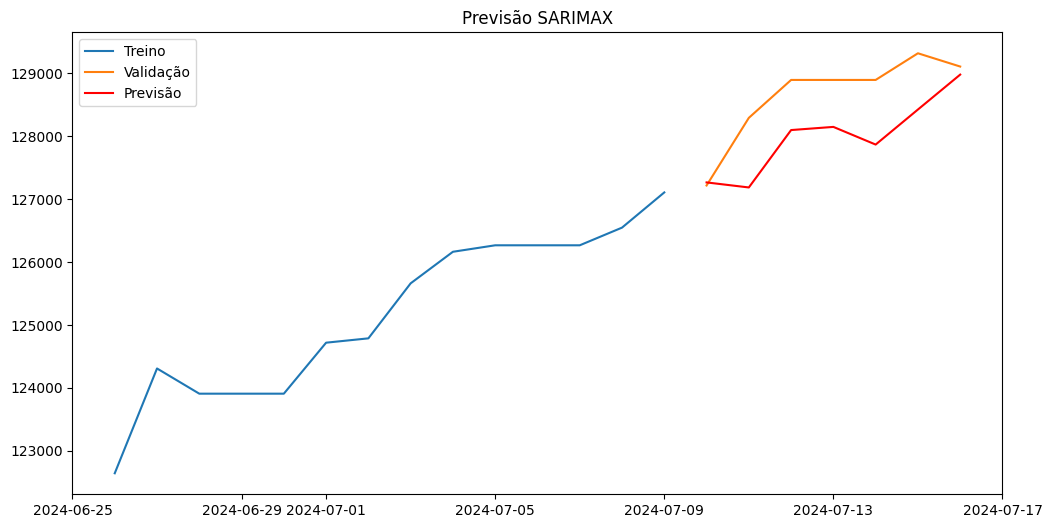

In [362]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, last_14_train['y'], label='Treino')
plt.plot(val_df.index, val_df['y'], label='Valida√ß√£o')
plt.plot(val_df.index, forecast_sarimax, label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o SARIMAX')
plt.show()

## Modelo **XGBoost**

In [363]:
df_modelo_xg = df_modelo_prophet.copy()

In [364]:
df_modelo_xg

ds       y  abertura
0    2020-07-21  104310    104426
1    2020-07-22  104290    104312
2    2020-07-23  102293    104291
3    2020-07-24  102382    102292
4    2020-07-25  102382    102292
...         ...     ...       ...
1455 2024-07-15  129321    128898
1456 2024-07-16  129110    129322
1457 2024-07-17  129450    129112
1458 2024-07-18  127652    129450
1459 2024-07-19  127616    127652

[1460 rows x 3 columns]

In [365]:
# Criar features baseadas em lags (atrasos)
df_modelo_xg["year"] = df_modelo_xg["ds"].dt.year
df_modelo_xg["month"] = df_modelo_xg["ds"].dt.month
df_modelo_xg["day"] = df_modelo_xg["ds"].dt.day
df_modelo_xg["day_of_week"] = df_modelo_xg["ds"].dt.dayofweek


In [366]:
FEATURES = ["year","month","day","day_of_week"]
TARGET = "y"

In [367]:
df_modelo_xg

ds       y  abertura  year  month  day  day_of_week
0    2020-07-21  104310    104426  2020      7   21            1
1    2020-07-22  104290    104312  2020      7   22            2
2    2020-07-23  102293    104291  2020      7   23            3
3    2020-07-24  102382    102292  2020      7   24            4
4    2020-07-25  102382    102292  2020      7   25            5
...         ...     ...       ...   ...    ...  ...          ...
1455 2024-07-15  129321    128898  2024      7   15            0
1456 2024-07-16  129110    129322  2024      7   16            1
1457 2024-07-17  129450    129112  2024      7   17            2
1458 2024-07-18  127652    129450  2024      7   18            3
1459 2024-07-19  127616    127652  2024      7   19            4

[1460 rows x 7 columns]

In [368]:
train_size = df_modelo_xg.shape[0] - 10
train_df = df_modelo_xg[:train_size]
val_df = df_modelo_xg[train_size:-3]

In [369]:
val_df

ds       y  abertura  year  month  day  day_of_week
1450 2024-07-10  127218    127109  2024      7   10            2
1451 2024-07-11  128294    127221  2024      7   11            3
1452 2024-07-12  128897    128293  2024      7   12            4
1453 2024-07-13  128897    128293  2024      7   13            5
1454 2024-07-14  128897    128293  2024      7   14            6
1455 2024-07-15  129321    128898  2024      7   15            0
1456 2024-07-16  129110    129322  2024      7   16            1

In [370]:
# Preparar os dados para XGBoost
x_train, y_train = train_df[FEATURES],train_df[TARGET]
x_val, y_val = val_df[FEATURES], val_df[TARGET]

In [371]:
train_df.head()

ds       y  abertura  year  month  day  day_of_week
0 2020-07-21  104310    104426  2020      7   21            1
1 2020-07-22  104290    104312  2020      7   22            2
2 2020-07-23  102293    104291  2020      7   23            3
3 2020-07-24  102382    102292  2020      7   24            4
4 2020-07-25  102382    102292  2020      7   25            5

In [372]:
# Ajustar o modelo XGBoost
model_xg = XGBRegressor(objective='reg:squarederror')
model_xg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [373]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
y_pred = model_xg.predict(x_val)

In [374]:
# Calcular o erro de previs√£o
erros_xg = calculate_errors(y_val, y_pred)
print_errors(y_val,y_pred)

MAE (Mean Absolute Error): 3315.0401785714284
MSE (Mean Squared Error): 12924148.078526089
MAPE (Mean Absolute Percentage Error): 2.571417270474337%


In [375]:
# Selecionar os √∫ltimos 14 registros de cada DataFrame
last_14_train = train_df.iloc[-14:]

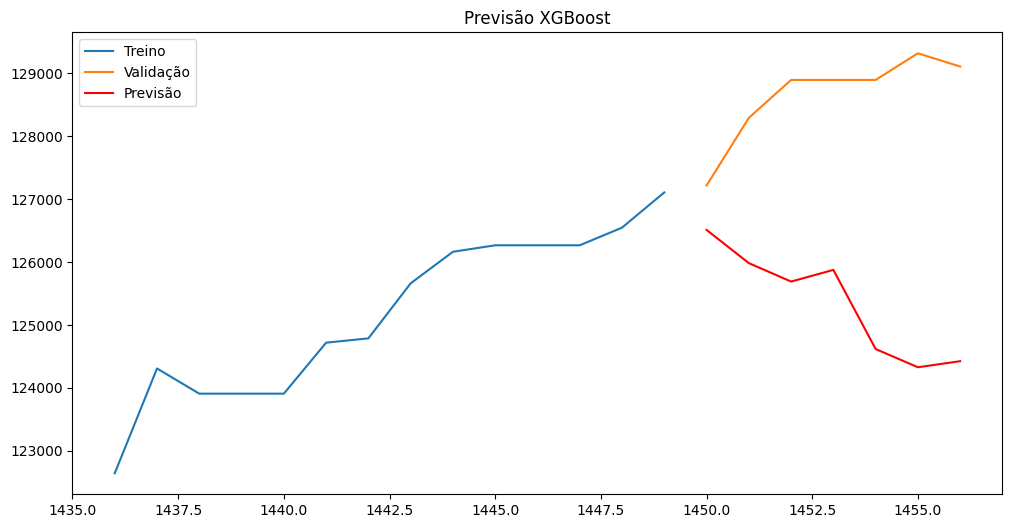

In [376]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train.index, y_train.iloc[-14:], label='Treino')
plt.plot(val_df.index, y_val, label='Valida√ß√£o')
plt.plot(val_df.index, y_pred, label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o XGBoost')
plt.show()

## Compara√ß√£o dos Resultados

In [377]:
df_resultado = pd.DataFrame(
    [erros_arima,erros_sarima,erros_exp_smoo,erros_prophet,erros_sarimax,erros_xg],
    columns=['MAE','MSE','MAPE'],
    index=["Arima","Sarima"," Exponential Smoothing","Prophet","Sarimax","XGBoost"]
)
df_resultado

MAE           MSE      MAPE
Arima                   1599.428571  2.993567e+06  1.240520
Sarima                  1593.515590  2.981995e+06  1.235902
 Exponential Smoothing  1482.511802  2.562309e+06  1.149885
Prophet                  589.669785  4.326131e+05  0.457979
Sarimax                  678.721454  6.135404e+05  0.526861
XGBoost                 3315.040179  1.292415e+07  2.571417

### An√°lise dos resultados dos modelos

Caros investidores, como podem perceber utilizamos alguns modelos dispon√≠veis para realizar os treinos, apenas para mostrar para os senhores as op√ß√µes dispon√≠veis e seus respectivos desempenho.

Na tabela abaixo, comparando os resultados podemos verificar que o Prophet obteve o melhor desempenho, com aproximadamente 0.46% de Erro Percentual Absoluto M√©dio (MAPE). Considerando assim, uma acur√°cia de 99.54%.

O modelo Prophet, desenvolvido pelo Facebook, projetado para lidar com dados que apresentam sazonalidade e tend√™ncias. Apesar desse modelo n√£o est√° sendo mais evolu√≠do desde 2023, optamos por aprimorar a escolha dos hiperpar√¢metros do Prophet para tentar alcan√ßar um resultado ainda melhor.

## Encontrando os melhores **hiperpar√¢metros** para o **Prophet**

In [378]:
df_modelo_prophet = df_novo.reset_index()

# Dividir o dataframe em treino e valida√ß√£o
train_size_prophet = df_modelo_prophet.shape[0] - 10
train_df_prophet = df_modelo_prophet[:train_size_prophet]
val_df_prophet = df_modelo_prophet[train_size_prophet:-3]

In [379]:
#fun√ß√£o para criar o modelo prophet:
def create_model(params):
    model = Prophet(
        changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
        seasonality_mode=params.get('seasonality_mode', 'additive'),
        seasonality_prior_scale=params.get('seasonality_prior_scale', 10.0),
        holidays_prior_scale=params.get('holidays_prior_scale', 10.0),
    )
    return model


In [380]:
#fun√ß√£o para avaliar o modelo:
def evaluate_model(model, X, y):
    model.fit(X)
    future = model.make_future_dataframe(periods=len(y), include_history=False)
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    return mean_absolute_error(y, y_pred)


In [381]:
#Definindo os hiperpar√¢metros:
param_distributions = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}


In [382]:
#Fun√ß√£o para criar estimador
class ProphetEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, changepoint_prior_scale=0.05, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = self.create_model()

    def create_model(self):
        return Prophet(
            changepoint_prior_scale=self.changepoint_prior_scale,
            seasonality_mode=self.seasonality_mode,
            seasonality_prior_scale=self.seasonality_prior_scale,
            holidays_prior_scale=self.holidays_prior_scale
        )

    def fit(self, X, y):
        df = pd.DataFrame({'ds': X, 'y': y})
        self.model.fit(df)
        return self

    def predict(self, X):
        future = pd.DataFrame({'ds': X})
        forecast = self.model.predict(future)
        return forecast['yhat']

    def get_params(self, deep=True):
        return {
            'changepoint_prior_scale': self.changepoint_prior_scale,
            'seasonality_mode': self.seasonality_mode,
            'seasonality_prior_scale': self.seasonality_prior_scale,
            'holidays_prior_scale': self.holidays_prior_scale
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        self.model = self.create_model()
        return self

# Fun√ß√£o para validar o modelo
def validate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring=make_scorer(mean_absolute_error), cv=5)
    return scores.mean()


In [383]:
param_distributions

{'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
 'seasonality_mode': ['additive', 'multiplicative'],
 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
 'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

In [384]:
#Realizar Randomized Search com Valida√ß√£o Cruzada
# Preparar os dados de treino
X = train_df_prophet['ds']
y = train_df_prophet['y']

# Definir o modelo ProphetEstimator para RandomizedSearchCV
model = ProphetEstimator()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,  # N√∫mero de combina√ß√µes aleat√≥rias a serem testadas
    scoring=make_scorer(mean_absolute_error),
    cv=5,  # N√∫mero de folds para valida√ß√£o cruzada
    random_state=42
)

# Executar RandomizedSearchCV
random_search.fit(X, y)

# Exibir os melhores hiperpar√¢metros e a melhor pontua√ß√£o
print("Melhores par√¢metros encontrados:", random_search.best_params_)
print("Melhor pontua√ß√£o (MAE):", random_search.best_score_)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/aquue6fo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/_4czk2wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85413', 'data', 'file=/tmp/tmpr1k3cbpl/aquue6fo.json', 'init=/tmp/tmpr1k3cbpl/_4czk2wp.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_modeln8qtq6hm/prophet_model-20240727171824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1

Melhores par√¢metros encontrados: {'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5}
Melhor pontua√ß√£o (MAE): 16653.329507144877


In [431]:
train_df_prophet.tail()

ds       y  abertura
981 2024-07-01  124718    123905
982 2024-07-02  124787    124720
983 2024-07-03  125662    124787
984 2024-07-04  126164    125666
985 2024-07-05  126267    126165

In [385]:
# Ajustar o modelo Prophet
#Melhores par√¢metros encontrados: {'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5}
model_prophet_best_param = Prophet(changepoint_range= 0.5,
                                   changepoint_prior_scale= 1.0,
                                   holidays_prior_scale= 0.01,
                                   seasonality_mode= 'additive'
                        )

model_prophet_best_param.add_regressor("abertura")
model_prophet_best_param.fit(train_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/ldktd7v5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr1k3cbpl/o1x6vjke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39784', 'data', 'file=/tmp/tmpr1k3cbpl/ldktd7v5.json', 'init=/tmp/tmpr1k3cbpl/o1x6vjke.json', 'output', 'file=/tmp/tmpr1k3cbpl/prophet_modelh0aqs8uf/prophet_model-20240727171854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [417]:
# Fazer previs√µes para o per√≠odo de valida√ß√£o
future = model_prophet_best_param.make_future_dataframe(periods=len(val_df_prophet),freq='B') #dias uteis
# Adicionar o regressor correspondente ao futuro DataFrame
future['abertura'] = val_df_prophet['abertura'].astype(int)
future['abertura'] = future['abertura'].fillna(0).astype(int)
forecast_prophet_best_param = model_prophet_best_param.predict(future)

In [418]:
print(forecast_prophet_best_param[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds           yhat     yhat_lower     yhat_upper
988 2024-07-10  127390.466399  125660.343767  128993.087020
989 2024-07-11  127551.410439  125926.617224  129199.884241
990 2024-07-12  128477.497104  126775.947176  130236.005926
991 2024-07-15  129119.492855  127411.689700  130736.030074
992 2024-07-16  129669.946542  127959.527889  131314.595019


In [419]:
# Extrair as previs√µes para o per√≠odo de valida√ß√£o
forecast_val_best_param = forecast_prophet_best_param[['ds', 'yhat']].set_index('ds').loc[val_df_prophet['ds']]

In [420]:
forecast_val_best_param

yhat
ds                       
2024-07-08  126491.691080
2024-07-09  126891.007584
2024-07-10  127390.466399
2024-07-11  127551.410439
2024-07-12  128477.497104
2024-07-15  129119.492855
2024-07-16  129669.946542

In [390]:
# Calcular o erro de previs√£o
erros_prophet_best_param = calculate_errors(val_df_prophet['y'], forecast_val_best_param['yhat'].round().astype(int))
print_errors(val_df_prophet['y'],forecast_val_best_param['yhat'].round().astype(int))

MAE (Mean Absolute Error): 338.57142857142856
MSE (Mean Squared Error): 166094.57142857142
MAPE (Mean Absolute Percentage Error): 0.2635847397366094%


In [391]:
# Selecionar os √∫ltimos 14 registros de cada DataFrame
last_14_train = train_df_prophet.iloc[-14:]

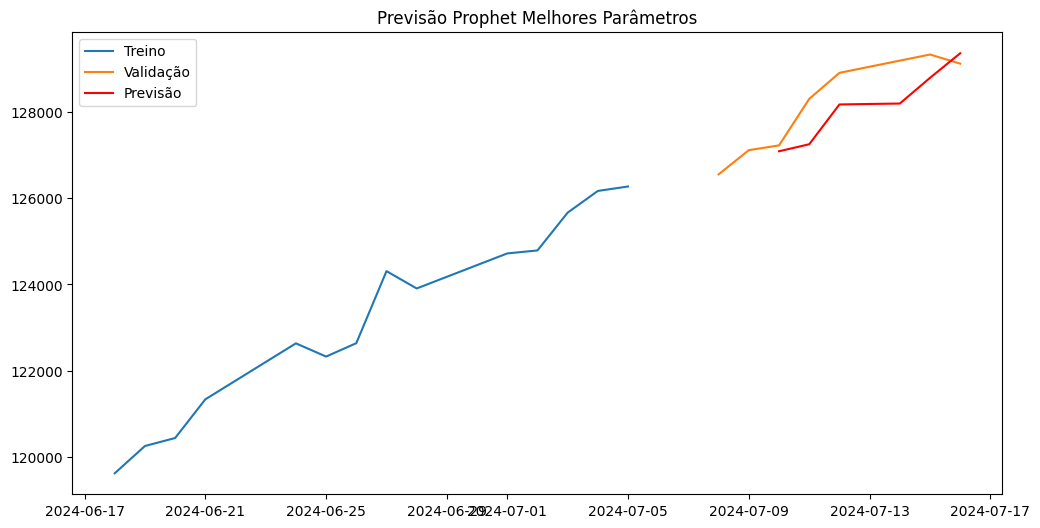

In [392]:
# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(last_14_train['ds'], last_14_train['y'], label='Treino')
plt.plot(val_df_prophet['ds'], val_df_prophet['y'], label='Valida√ß√£o')
plt.plot(forecast_val.index, forecast_val['yhat'], label='Previs√£o', color='red')
plt.legend()
plt.title('Previs√£o Prophet Melhores Par√¢metros')
plt.show()

## Comparando os resultados dos modelo Prophet:


In [393]:
df_resultado_prophet = pd.DataFrame(
    [erros_prophet,erros_prophet_best_param],
    columns=['MAE','MSE','MAPE'],
    index=["Prophet","Prophet - Melhores Par√¢metros"]
)
df_resultado_prophet

MAE            MSE      MAPE
Prophet                        589.669785  432613.115736  0.457979
Prophet - Melhores Par√¢metros  338.571429  166094.571429  0.263585

### Conclus√£o

Com a utiliza√ß√£o do algoritmo 'Randomized Search com Valida√ß√£o Cruzada', conseguimos aprimorar os resultados do modelo Prophet, diminuindo o Erro Percentual Absoluto M√©dio (MAPE) de aproximadamente 0.46% para 0.26%.

Conclu√≠mos que o Prophet aprimorado obteve a melhor acur√°cia, sugerimos assim que os senhores utilizem esse modelo para prever os pr√≥ximos dias do Ibovespa.

Como evolu√ß√µes para o futuro, poderemos utilizar t√©cnicas de redes neurais para prever com maior precis√£o.